# Chapter 7: Image Generation with Variational Autoencoders (VAEs)


This chapter covers

* Autoencoders and variational autoencoders (VAEs) and their differences 
* Building and training an autoencoder from scratch to generate handwritten digits
* Building and training a VAE from scratch to generate human face images
* Performing encoding arithmetic with the trained VAE


So far, you have learned how to generate shapes, numbers, and images, all by using generative adversarial networks (GANs). In this chapter, you’ll learn to create images by using another generative model: autoencoders (AEs) and their variant, variational autoencoders (VAEs). You’ll also learn the practical uses of VAEs by performing encoding arithmetic and encoding interpolation. 
AEs have a dual-component structure: an encoder and a decoder. The encoder compresses the data into an abstract representation in a lower-dimensional space (the latent space), and the decoder decompresses the encoded information and reconstructs the data. 

The primary goal of an AE is to learn a compressed representation of the input data, focusing on minimizing the reconstruction error - the difference between the original input and its reconstruction (at the pixel level, as we have seen in Chapter 6 when calculating cycle consistency loss). The encoder-decoder architecture is a cornerstone in various generative models, including Transformers, which you’ll explore in detail in the latter half of this book. For example, in Chapter 9, you'll build a Transformer for translating English to French: the encoder converts an English phrase into an abstract vector representation while the decoder constructs the French translation based on the compressed representation generated by the encoder. Text-to-image Transformers like DALL-E 2 and Imagen also utilize an autoencoder architecture in their design. This involves first encoding an image into a compact, low-dimensional probability distribution. Then, they decode from this distribution. Of course, what constitutes an encoder and a decoder is different in different models.    

Your first project in this chapter involves constructing and training an AE from scratch to generate handwritten digits. You’ll use 60,000 grayscale images of handwritten digits (0 to 9), each with a size of 28x28=784 pixels, as the training data. The encoder in the AE compresses each image into a deterministic vector representation with only 20 values. The decoder in the AE reconstructs the image with the aim of minimizing the difference between the original image and the reconstructed image. This is achieved by minimizing the mean absolute error between the two images, at the pixel level. The end result is an AE capable of generating handwritten digits almost identical to those in the training set. 

While AEs are good at replicating the input data, they often falter in generating new samples that are not present in the training set. More importantly, AEs are not good at input interpolation: they often fail to generate intermediate representations between two input data points. This leads us to variational autoencoders (VAEs). VAEs differ from AEs in two critical ways. Firstly, while an AE encodes each input into a specific point in the latent space, a VAE encodes it into a probability distribution within this space. Secondly, an AE focuses solely on minimizing the reconstruction error, whereas a VAE learns the parameters of the probability distribution for latent variables, minimizing a loss function that includes both reconstruction loss and a regularization term, the Kullback-Liebler (KL) divergence. 

The KL-divergence encourages the latent space to approximate a normal distribution and ensures that the latent variables don't just memorize the training data but rather capture the underlying distribution. It helps in achieving a well-structured latent space where similar data points are mapped closely together, making the space continuous and interpretable. As a result, we can manipulate the encodings to achieve new outcomes, which makes encoding arithmetic and input interpolation possible in VAEs. 

In the second project in this chapter, you’ll build and train a VAE from the ground up to generate human face images. Here, your training set comprises eyeglasses images that you downloaded in Chapter 5. The VAE’s encoder compresses an image of size 3x256x256=196,608 pixels into a 100-value probabilistic vector, each following a normal distribution. The decoder then reconstructs the image based on this probabilistic vector. The trained VAE can not only replicate human faces from the training set but also generate novel ones. 

You’ll learn how to conduct encoding arithmetic and input interpolation in VAEs. You’ll manipulate the encoded representations (latent vectors) of different inputs to achieve specific outcomes (i.e., with or without certain characteristics in images) when decoded. The latent vectors control different characteristics in the decoded images such as gender, whether there are eyeglasses in an image, and so on. For example, you can first obtain the latent vectors for men with glasses (z1), women with glasses (z2), and women without glasses (z3). You then calculate a new latent vector, z4=z1-z2+z3. Since both z1 and z2 lead to eyeglasses in images when decoded, z1-z2 cancels out eyeglasses features in the resulting image. Similarly, since both z2 and z3 lead to a female face, z3-z2 cancels out female features in the resulting image. Therefore, if you decode z4=z1-z2+z3 with the trained VAE, you’ll get an image of a man without glasses.

You’ll also create a series of images transitioning from a woman with glasses to a woman without glasses by varying the weight assigned to the latent vectors z1 and z2 above. These exercises exemplify the versatility and creative potential of VAEs in the field of generative models.
Compared to generative adversarial networks (GANs) that we studied in the last few chapters, AEs and VAEs have a simple architecture and are easy to construct. Further, AEs and VAEs are generally easier and more stable to train relative to GANs. However, images generated by AEs and VAEs tend to be blurrier or less sharp compared to those generated by GANs. GANs excel in generating high-quality, realistic images but suffer from training difficulties and resource intensiveness. The choice between GANs and VAEs largely depends on the specific requirements of the task at hand, including the desired quality of the output, computational resources available, and the importance of having a stable training process. 

VAEs have a wide range of practical applications in the real world. Consider, for instance, you run an eyewear store and have successfully marketed a new style of men's glasses online. Now, you wish to target the female market with the same style, but lack images of women wearing these glasses and face high costs for a professional photo shoot. Here's where VAEs come into play: you can combine existing images of men wearing the glasses with pictures of both men and women without glasses. This way, you can create realistic images of women sporting the same eyewear style through encoding arithmetic, a technique you’ll learn in this chapter. 
 
In another scenario, suppose your store offers eyeglasses with dark and light frames, both of which are popular. You want to introduce a middle option with frames of an intermediate shade. With VAEs, through a method called encoding interpolation, you can effortlessly generate a smooth transition series of images. These images would vary from dark to light-framed glasses, offering customers a visual spectrum of choices. 
 
The use of VAEs is not limited to eyeglasses; it extends to virtually any product category, be it clothing, furniture, or food. The technology provides a creative and cost-effective solution for visualizing and marketing a wide range of products. Furthermore, although image generation is a prominent example, VAEs can be applied to many other types of data, including music and text. Their versatility opens up endless possibilities in terms of practical use!

# 1. An overview of autoencoders


# 2. Build and train an autoencoder to generate digits


## 2.1. Gather handwritten digits

In [1]:
import torchvision
import torchvision.transforms as T

transform=T.Compose([
    T.ToTensor()])
train_set=torchvision.datasets.MNIST(root=".",
    train=True,download=True,transform=transform) 
test_set=torchvision.datasets.MNIST(root=".",
    train=False,download=True,transform=transform) 

In [2]:
import torch

batch_size=32
train_loader=torch.utils.data.DataLoader(
    train_set,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(
    test_set,batch_size=batch_size,shuffle=True)

## 2.2. Build and train an autoencoder


In [3]:
import torch.nn.functional as F
from torch import nn

# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"
input_dim = 784
z_dim = 20
h_dim = 200
class AE(nn.Module):
    def __init__(self,input_dim,z_dim,h_dim):
        super().__init__()
        self.common = nn.Linear(input_dim, h_dim)
        self.encoded = nn.Linear(h_dim, z_dim)
        self.l1 = nn.Linear(z_dim, h_dim)
        self.decode = nn.Linear(h_dim, input_dim)                
    def encoder(self, x):
        common = F.relu(self.common(x))
        mu = self.encoded(common)
        return mu
    def decoder(self, z):
        out=F.relu(self.l1(z))
        out=torch.sigmoid(self.decode(out))
        return out
    def forward(self, x):
        mu=self.encoder(x)
        out=self.decoder(mu)
        return out, mu

In [4]:
model = AE(input_dim,z_dim,h_dim).to(device)
lr=0.00025
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [5]:
import matplotlib.pyplot as plt

# collect a sample for each digit
originals = []
idx = 0
for img,label in test_set:
    if label == idx:
        originals.append(img)
        idx += 1
    if idx == 10:
        break

def plot_digits():
    reconstructed=[]
    for idx in range(10):
        # reconstruct the digit image
        with torch.no_grad():
            img = originals[idx].reshape((1,input_dim))
            out,mu = model(img.to(device))
        reconstructed.append(out)
    # Plot both the original and the reconstructed
    imgs=originals+reconstructed
    plt.figure(figsize=(10,2),dpi=50)
    for i in range(20):
        ax = plt.subplot(2,10, i + 1)
        img=(imgs[i]).detach().cpu().numpy()
        plt.imshow(img.reshape(28,28),
                   cmap="binary")
        plt.xticks([])
        plt.yticks([])
    plt.show()  

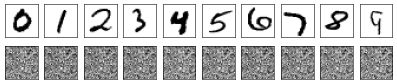

In [6]:
plot_digits()

In [7]:
for epoch in range(10):
    tloss=0
    for imgs, labels in train_loader:
        # reconstruct the images
        imgs=imgs.to(device).view(-1, input_dim)
        out, mu=model(imgs)
        # reconstruction loss (MSE)
        loss=((out-imgs)**2).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tloss+=loss.item()
    print(f"at epoch {epoch} toal loss = {tloss}")
    # visualize the reconstructed digits
    plot_digits()

## 2.3. Save and Use the trained Autoencoder


In [8]:
# Export to TorchScript
scripted = torch.jit.script(model) 
# Save the model
scripted.save('files/AEdigits.pt') 

In [9]:
model=torch.jit.load('files/AEdigits.pt',map_location=device)
model.eval()

RecursiveScriptModule(
  original_name=VAE
  (common): RecursiveScriptModule(original_name=Linear)
  (encoded): RecursiveScriptModule(original_name=Linear)
  (l1): RecursiveScriptModule(original_name=Linear)
  (decode): RecursiveScriptModule(original_name=Linear)
)

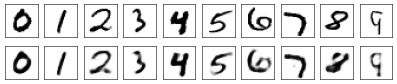

In [10]:
plot_digits()

# 3. What Are Variational Autoencoders?

# 4. A VAE to Generate Human Face Images
## 4.1. Build a VAE

In [11]:
transform = T.Compose([
            T.Resize(256),
            T.ToTensor(),
            ])
data = torchvision.datasets.ImageFolder(
    root="files/glasses",
    transform=transform)
batch_size=16
loader = torch.utils.data.DataLoader(data,
     batch_size=batch_size,shuffle=True)

In [12]:
latent_dims=100
class Encoder(nn.Module):
    def __init__(self, latent_dims=100):  
        super().__init__()
        # input 256 by 256 by 3 channels
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding=1)
        # 128 by 128 with 8 channels
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        # 64 by 64 with 16 channels
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        # 31 by 31 with 32 channels
        self.linear1 = nn.Linear(31*31*32, 1024)
        self.linear2 = nn.Linear(1024, latent_dims)
        self.linear3 = nn.Linear(1024, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() 
        self.N.scale = self.N.scale.cuda()

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        std = torch.exp(self.linear3(x))
        z = mu + std*self.N.sample(mu.shape)
        return mu, std, z  

In [13]:
class Decoder(nn.Module):   
    def __init__(self, latent_dims=100):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 31*31*32),
            nn.ReLU(True))
        self.unflatten = nn.Unflatten(dim=1, 
                  unflattened_size=(32,31,31))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,stride=2,
                               output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2,
                               padding=1, output_padding=1))
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x  

In [14]:
class VAE(nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    def forward(self, x):
        x = x.to(device)
        mu, std, z = self.encoder(x)
        return mu, std, self.decoder(z) 

In [15]:
vae=VAE().to(device)
lr=1e-4 
optimizer=torch.optim.Adam(vae.parameters(),
                           lr=lr,weight_decay=1e-5)

## 4.2. Train the Variational Autoencoder


In [16]:
def train_epoch(epoch):
    vae.train()
    epoch_loss = 0.0
    for imgs, _ in loader: 
        imgs = imgs.to(device)
        mu, std, out = vae(imgs)
        # reconstruction loss
        reconstruction_loss = ((imgs-out)**2).sum() 
        # kl loss
        kl = ((std**2)/2 + (mu**2)/2 - torch.log(std) - 0.5).sum()
        # total loss
        loss = reconstruction_loss + kl
        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        epoch_loss+=loss.item()
    print(f'at epoch {epoch}, loss is {epoch_loss}')  

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_epoch():
    with torch.no_grad():
        noise = torch.randn(18,latent_dims).to(device)
        imgs = vae.decoder(noise).cpu()
        imgs = torchvision.utils.make_grid(imgs,6,3).numpy()
        fig, ax = plt.subplots(figsize=(6,3),dpi=100)
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis("off")
        plt.show()      

In [18]:
for epoch in range(1,11):
    train_epoch(epoch)
    plot_epoch()
torch.save(vae.state_dict(),"files/VAEglasses.pth")    

## 4.3. Generate Images with the Trained Model


In [19]:
vae.eval()
vae.load_state_dict(torch.load('files/VAEglasses.pth',
                              map_location=device))

<All keys matched successfully>

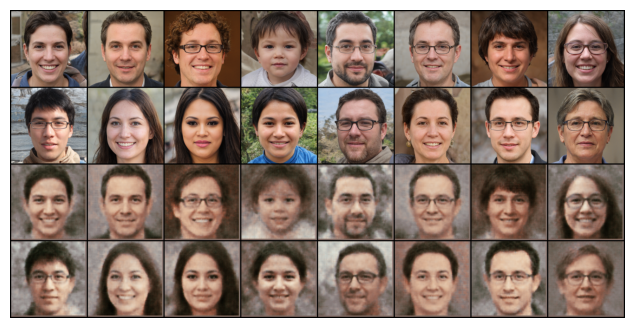

In [20]:
# compare original with reconstructed
imgs,_=next(iter(loader))
imgs = imgs.to(device)
mu, std, out = vae(imgs)
images=torch.cat([imgs,out],dim=0).detach().cpu()
images = torchvision.utils.make_grid(images,8,4)
fig, ax = plt.subplots(figsize=(8,4),dpi=100)
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.axis("off")
plt.show()      

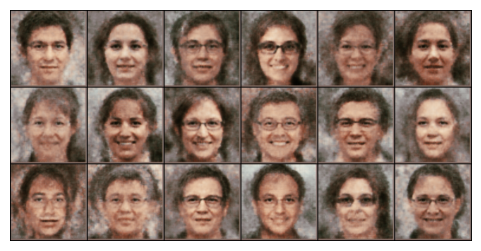

In [21]:
plot_epoch()  

## 4.4. Encoding Arithmetic with the Trained VAE


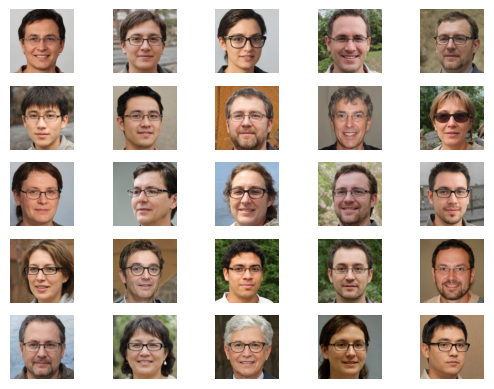

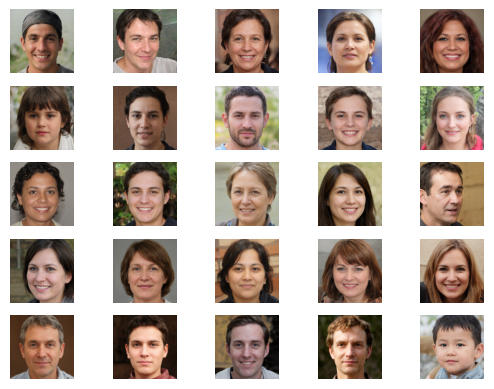

In [22]:
# to replicate results from this point on, download trained model at
# https://gattonweb.uky.edu/faculty/lium/gai/VAEglasses.zip
# collect 25 five images with glasses
torch.manual_seed(0)  # make sure you fix the random state
glasses=[]
for i in range(25):
    img,label=data[i]
    glasses.append(img)
    plt.subplot(5,5,i+1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.axis("off")
plt.show()
# select three men's images    
men_g=[glasses[0],glasses[3],glasses[14]]
# select three women's images    
women_g=[glasses[9],glasses[15],glasses[21]] 

# collect 25 five images without glasses
noglasses=[]
for i in range(25):
    img,label=data[-i-1]
    noglasses.append(img)
    plt.subplot(5,5,i+1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.axis("off")
plt.show()
# select three men's images    
men_ng=[noglasses[1],noglasses[7],noglasses[22]]
# select three women's images    
women_ng=[noglasses[4],noglasses[9],noglasses[19]]

In [23]:
# create a batch of images of men with glasses
men_g_batch = torch.cat((men_g[0].unsqueeze(0),    #A
             men_g[1].unsqueeze(0),
             men_g[2].unsqueeze(0)), dim=0).to(device)
# Obtain the three encodings
_,_,men_g_encodings=vae.encoder(men_g_batch)
# Average over the three images to obtain the encoding for the group
men_g_encoding=men_g_encodings.mean(dim=0)    #B
# Decode the average encoding to create an image of a man with glasses 
men_g_recon=vae.decoder(men_g_encoding.unsqueeze(0))    #C

# Do the same for the other three groups
# group 2, women with glasses
women_g_batch = torch.cat((women_g[0].unsqueeze(0),
             women_g[1].unsqueeze(0),
             women_g[2].unsqueeze(0)), dim=0).to(device)
# group 3, men without glasses
men_ng_batch = torch.cat((men_ng[0].unsqueeze(0),
             men_ng[1].unsqueeze(0),
             men_ng[2].unsqueeze(0)), dim=0).to(device)
# group 4, women without glasses
women_ng_batch = torch.cat((women_ng[0].unsqueeze(0),
             women_ng[1].unsqueeze(0),
             women_ng[2].unsqueeze(0)), dim=0).to(device)
# obtain average encoding for each group
_,_,women_g_encodings=vae.encoder(women_g_batch)
women_g_encoding=women_g_encodings.mean(dim=0)
_,_,men_ng_encodings=vae.encoder(men_ng_batch)
men_ng_encoding=men_ng_encodings.mean(dim=0)
_,_,women_ng_encodings=vae.encoder(women_ng_batch)
women_ng_encoding=women_ng_encodings.mean(dim=0)    #D
# decode for each group
women_g_recon=vae.decoder(women_g_encoding.unsqueeze(0))
men_ng_recon=vae.decoder(men_ng_encoding.unsqueeze(0))
women_ng_recon=vae.decoder(women_ng_encoding.unsqueeze(0))    #E

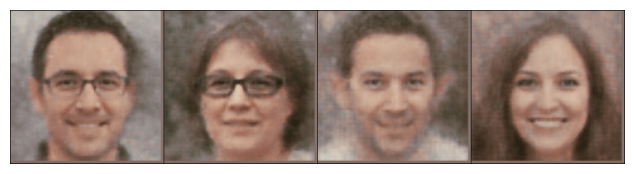

In [24]:
imgs=torch.cat((men_g_recon,
                women_g_recon,
                men_ng_recon,
                women_ng_recon),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show()

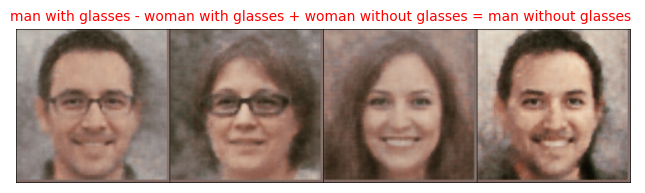

In [25]:
z=men_g_encoding-women_g_encoding+women_ng_encoding
out=vae.decoder(z.unsqueeze(0))
imgs=torch.cat((men_g_recon,
                women_g_recon,
                women_ng_recon,out),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.title("man with glasses - woman \
with glasses + woman without \
glasses = man without glasses ",fontsize=10,c="r")
plt.axis("off")
plt.show()

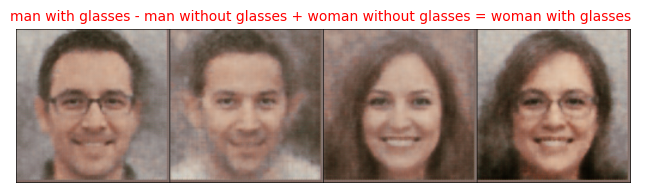

In [26]:
# Exercise 7.1 (i)
z=men_g_encoding-men_ng_encoding+women_ng_encoding
out=vae.decoder(z.unsqueeze(0))
imgs=torch.cat((men_g_recon,
                men_ng_recon,
                women_ng_recon,out),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.title("man with glasses - man \
without glasses + woman without \
glasses = woman with glasses ",fontsize=10,c="r")
plt.axis("off")
plt.show()

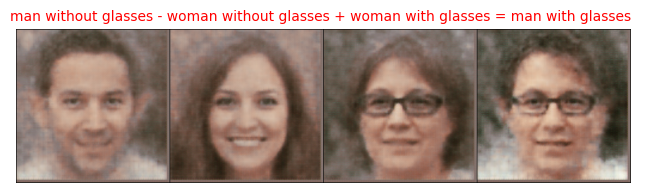

In [27]:
# Exercise 7.1 (ii)
z=men_ng_encoding-women_ng_encoding+women_g_encoding
out=vae.decoder(z.unsqueeze(0))
imgs=torch.cat((men_ng_recon,
                women_ng_recon,
                women_g_recon,out),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.title("man without glasses - woman \
without glasses + woman with \
glasses = man with glasses ",fontsize=10,c="r")
plt.axis("off")
plt.show()

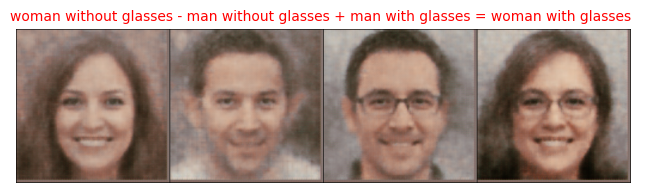

In [28]:
# Exercise 7.1 (iii)
z=women_ng_encoding-men_ng_encoding+men_g_encoding
out=vae.decoder(z.unsqueeze(0))
imgs=torch.cat((women_ng_recon,
                men_ng_recon,
                men_g_recon,out),dim=0)
imgs=torchvision.utils.make_grid(imgs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.title("woman without glasses - man \
without glasses + man with \
glasses = woman with glasses ",fontsize=10,c="r")
plt.axis("off")
plt.show()

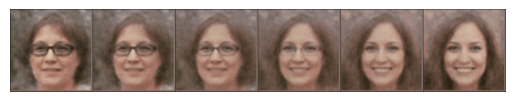

In [29]:
# woman with glasses to woman without glasses
results=[]
for w in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    z=w*women_ng_encoding+(1-w)*women_g_encoding
    out=vae.decoder(z.unsqueeze(0))
    results.append(out)
imgs=torch.cat((results[0],results[1],results[2],
                results[3],results[4],results[5]),dim=0)
imgs=torchvision.utils.make_grid(imgs,6,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show() 

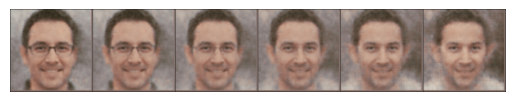

In [30]:
# Exercise 7.2 (i)
# man with glasses to man without glasses
results=[]
for w in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    z=w*men_ng_encoding+(1-w)*men_g_encoding
    out=vae.decoder(z.unsqueeze(0))
    results.append(out)
imgs=torch.cat((results[0],results[1],results[2],
                results[3],results[4],results[5]),dim=0)
imgs=torchvision.utils.make_grid(imgs,6,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show() 

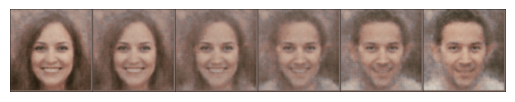

In [31]:
# Exercise 7.2 (ii)
# woman without glasses to man without glasses
results=[]
for w in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    z=w*men_ng_encoding+(1-w)*women_ng_encoding
    out=vae.decoder(z.unsqueeze(0))
    results.append(out)
imgs=torch.cat((results[0],results[1],results[2],
                results[3],results[4],results[5]),dim=0)
imgs=torchvision.utils.make_grid(imgs,6,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show() 

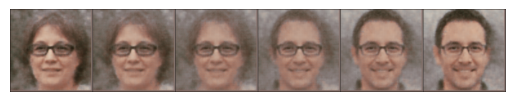

In [32]:
# Exercise 7.2 (iii)
# woman with glasses to man with glasses
results=[]
for w in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    z=w*men_g_encoding+(1-w)*women_g_encoding
    out=vae.decoder(z.unsqueeze(0))
    results.append(out)
imgs=torch.cat((results[0],results[1],results[2],
                results[3],results[4],results[5]),dim=0)
imgs=torchvision.utils.make_grid(imgs,6,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig, ax = plt.subplots(dpi=100)
plt.imshow(imgs)
plt.axis("off")
plt.show() 